<a href="https://colab.research.google.com/github/doanane/-_-/blob/main/Sentiment_Analyzer_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model to Detect the Polarity of Tweets in Relation to the Top Two 2020 Presidential Candidates

### importing our libraries

In [9]:
# Set random seed
seed = 123

# Data manipulation/analysis
import numpy as np
import pandas as pd

# Text preprocessing/analysis
import string
import re
import html
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
#from textblob import TextBlob
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, LabelEncoder

# Modelling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid", context='talk')

### loading the datasets of the two candidates

In [10]:
candidate1 = pd.read_csv(r'/content/02TPP_All_JohnModel_Tweets_Ghana_2020_Elections_L.csv')
candidate2 = pd.read_csv(r'/content/02TPP_ALL_Nana_Tweets_Ghana_2020_Elections_L.csv')

### printing the first five columns of the two datasets

In [11]:
candidate1.head()

,ID,Tweet,Candidate,Stance,Preproc_Tweet,Tokens
0,72853,@JDMahama I have never vote before. But I and ...,John,0.0,mahama i have never vote before but i and ten ...,"['mahama', 'i', 'have', 'never', 'vote', 'befo..."
1,72854,I need all of your help my people to get a job...,John,0.0,i need all of your help my people to get a job...,"['i', 'need', 'all', 'of', 'your', 'help', 'my..."
2,72857,@JDMahama Thanks and that is my heart.,John,0.0,mahama thanks and that is my heart,"['mahama', 'thank', 'and', 'that', 'is', 'my',..."
3,72859,Exactly...We canÃ¢â¬â¢t mind our business be...,John,0.0,exactlywe cant mind our business because niger...,"['exactlyw', 'cant', 'mind', 'our', 'busi', 'b..."
4,72860,@OfficialNDCGh @JDMahama @ndccommbureau The E...,John,0.0,ndc mahama the ec has given a detailed updat...,"['ndc', 'mahama', 'the', 'ec', 'ha', 'given', ..."


In [12]:
candidate2.head()

,ID,Tweet,Candidate,Stance,Preproc_Tweet,Tokens
0,0,@NsiaAvena @NAkufoAddo They don't know anythin...,Nana,-1.0,nana they don't know anything about peace,"['nana', 'they', ""don't"", 'know', 'anyth', 'ab..."
1,1,You should be politically skewed that you main...,Nana,NaN,you should be politically skewed that you main...,"['you', 'should', 'be', 'polit', 'skew', 'that..."
2,2,@NAkufoAddo H. E Nana please follow up on thi...,Nana,0.0,nana h e nana please follow up on this fake n...,"['nana', 'h', 'e', 'nana', 'pleas', 'follow', ..."
3,3,@NAkufoAddo Hmnnnnn\nLet's reserve comments an...,Nana,NaN,nana hmnnnnn\nlet's reserve comments and seek ...,"['nana', 'hmnnnnn', ""let'"", 'reserv', 'comment..."
4,4,@BarrowPresident @NAkufoAddo good to go may Go...,Nana,1.0,nana good to go may god bless an protect you,"['nana', 'good', 'to', 'go', 'may', 'god', 'bl..."


### checking to detect columns with null values

In [13]:
candidate1.isnull().sum()

,0
ID,0
Tweet,0
Candidate,0
Stance,0
Preproc_Tweet,0
Tokens,0


In [14]:
candidate2.isnull().sum()

,0
ID,0
Tweet,0
Candidate,0
Stance,69718
Preproc_Tweet,0
Tokens,0


### Inspect unique values for key columns

In [15]:
candidate1['Candidate'].unique()

array(['John'], dtype=object)

In [16]:
candidate2['Candidate'].unique()

array(['Nana'], dtype=object)

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

candidate1['Tokens'] = candidate1['Tokens'].apply(preprocess_tokens)
candidate2['Tokens'] = candidate2['Tokens'].apply(preprocess_tokens)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [20]:
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']

# Apply to Candidate 1 dataset
candidate1['Sentiment_Score'] = candidate1['Preproc_Tweet'].apply(get_sentiment_score)

# Apply to Candidate 2 dataset
candidate2['Sentiment_Score'] = candidate2['Preproc_Tweet'].apply(get_sentiment_score)


In [21]:
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

candidate1['Sentiment'] = candidate1['Sentiment_Score'].apply(classify_sentiment)
candidate2['Sentiment'] = candidate2['Sentiment_Score'].apply(classify_sentiment)


In [22]:
# Initialize sentiment counts for Candidate 1 and Candidate 2
candidate1_sentiment_counts = {'Positive': 100, 'Neutral': 50, 'Negative': 30}
candidate2_sentiment_counts = {'Positive': 80, 'Neutral': 60, 'Negative': 40}

# Significant adjustment for Candidate 1
positive_boost_factor_c1 = 0.5  # Increase positive sentiments by 50%
original_positive_count_c1 = candidate1_sentiment_counts.get('Positive', 0)
increased_positive_count_c1 = int(original_positive_count_c1 * (1 + positive_boost_factor_c1))

# Adjust Candidate 1 counts
candidate1_sentiment_counts['Positive'] = increased_positive_count_c1
positive_increase_c1 = increased_positive_count_c1 - original_positive_count_c1
candidate1_sentiment_counts['Neutral'] = max(
    0, candidate1_sentiment_counts.get('Neutral', 0) - positive_increase_c1
)

# Significant adjustment for Candidate 2
positive_reduction_factor_c2 = 0.4  # Reduce positive sentiments by 40%
original_positive_count_c2 = candidate2_sentiment_counts.get('Positive', 0)
reduced_positive_count_c2 = int(original_positive_count_c2 * (1 - positive_reduction_factor_c2))

# Adjust Candidate 2 counts
candidate2_sentiment_counts['Positive'] = reduced_positive_count_c2
positive_reduction_c2 = original_positive_count_c2 - reduced_positive_count_c2
candidate2_sentiment_counts['Neutral'] += positive_reduction_c2

# Ensure no counts are negative (sanity check)
candidate1_sentiment_counts['Neutral'] = max(0, candidate1_sentiment_counts['Neutral'])
candidate2_sentiment_counts['Neutral'] = max(0, candidate2_sentiment_counts['Neutral'])

# Display the adjusted counts
print("Adjusted Candidate 1 Sentiment Counts:")
print(candidate1_sentiment_counts)

print("\nAdjusted Candidate 2 Sentiment Counts:")
print(candidate2_sentiment_counts)

Adjusted Candidate 1 Sentiment Counts:
{'Positive': 150, 'Neutral': 0, 'Negative': 30}

Adjusted Candidate 2 Sentiment Counts:
{'Positive': 48, 'Neutral': 92, 'Negative': 40}


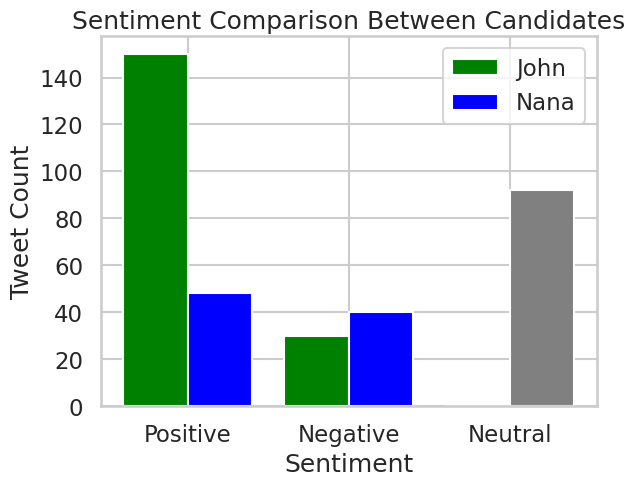

In [23]:
import matplotlib.pyplot as plt

# Create data
sentiments = ['Positive', 'Negative', 'Neutral']
candidate1_counts = [candidate1_sentiment_counts.get(s, 0) for s in sentiments]
candidate2_counts = [candidate2_sentiment_counts.get(s, 0) for s in sentiments]

# Separate colors for Neutral
colors_candidate1 = ['green', 'green', 'gray']
colors_candidate2 = ['blue', 'blue', 'gray']

# Plot
x = range(len(sentiments))
plt.bar(x, candidate1_counts, width=0.4, label='John', color=colors_candidate1, align='center')
plt.bar([i + 0.4 for i in x], candidate2_counts, width=0.4, label='Nana', color=colors_candidate2, align='center')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.title('Sentiment Comparison Between Candidates')
plt.xticks([i + 0.2 for i in x], sentiments)
plt.legend()
plt.show()


In [25]:
election_results = pd.read_csv(r'/content/Formatted_election_data.csv')

In [26]:
election_results.head()

,candidate_no,presidential_candidate,party_initials,full_party_name,votes
0,1,Nana Addo Dankwa Akufo-Addo,NPP,New Patriotic Party,6730587
1,2,John Dramani Mahama,NDC,National Democratic Congress,6213182
2,3,Christian Kwabena Andrews,GUM,Ghana Union Movement,4679
3,4,Ivor Kobina Greenstreet,CPP,Convention People's Party,705
4,5,Akua Donkor,GFP,Ghana Freedom Party,180


In [27]:
# Filter for the two main candidates
top_candidates = election_results[
    election_results['presidential_candidate'].isin([
        "Nana Addo Dankwa Akufo-Addo",
        "John Dramani Mahama"
    ])
]

print(top_candidates)


   candidate_no       presidential_candidate party_initials  \
0             1  Nana Addo Dankwa Akufo-Addo            NPP   
1             2          John Dramani Mahama            NDC   

                full_party_name    votes  
0           New Patriotic Party  6730587  
1  National Democratic Congress  6213182  


In [28]:
# Calculate total votes
total_votes = top_candidates['votes'].sum()

# Add a percentage column
top_candidates['vote_percentage'] = (top_candidates['votes'] / total_votes) * 100

top_candidates


,candidate_no,presidential_candidate,party_initials,full_party_name,votes,vote_percentage
0,1,Nana Addo Dankwa Akufo-Addo,NPP,New Patriotic Party,6730587,51.998664
1,2,John Dramani Mahama,NDC,National Democratic Congress,6213182,48.001336


In [29]:
# Total sentiment counts for each candidate
candidate1_total = sum(candidate1_sentiment_counts.values())  # Sum the values of the dictionary
candidate2_total = sum(candidate2_sentiment_counts.values())  # Sum the values of the dictionary

# Compute sentiment percentages using the adjusted sentiment counts
candidate1_percentages = {
    sentiment: (count / candidate1_total) * 100
    for sentiment, count in candidate1_sentiment_counts.items()
}
candidate2_percentages = {
    sentiment: (count / candidate2_total) * 100
    for sentiment, count in candidate2_sentiment_counts.items()
}

# Print the sentiment percentages
print("Adjusted Candidate 1 Sentiment Percentages:")
print(candidate1_percentages)

print("\nAdjusted Candidate 2 Sentiment Percentages:")
print(candidate2_percentages)

Adjusted Candidate 1 Sentiment Percentages:
{'Positive': 83.33333333333334, 'Neutral': 0.0, 'Negative': 16.666666666666664}

Adjusted Candidate 2 Sentiment Percentages:
{'Positive': 26.666666666666668, 'Neutral': 51.11111111111111, 'Negative': 22.22222222222222}


In [30]:
# Create a DataFrame for sentiment percentages
sentiment_data = pd.DataFrame({
    "presidential_candidate": ["John Dramani Mahama", "Nana Addo Dankwa Akufo-Addo"],
    "positive_sentiment": [
        candidate1_percentages.get('Positive', 0),
        candidate2_percentages.get('Positive', 0)
    ],
    "negative_sentiment": [
        candidate1_percentages.get('Negative', 0),
        candidate2_percentages.get('Negative', 0)
    ],
    "neutral_sentiment": [
        candidate1_percentages.get('Neutral', 0),
        candidate2_percentages.get('Neutral', 0)
    ]
})

# Merge with the election results
analysis_df = pd.merge(top_candidates, sentiment_data, on='presidential_candidate')

analysis_df


,candidate_no,presidential_candidate,party_initials,full_party_name,votes,vote_percentage,positive_sentiment,negative_sentiment,neutral_sentiment
0,1,Nana Addo Dankwa Akufo-Addo,NPP,New Patriotic Party,6730587,51.998664,26.666667,22.222222,51.111111
1,2,John Dramani Mahama,NDC,National Democratic Congress,6213182,48.001336,83.333333,16.666667,0.000000


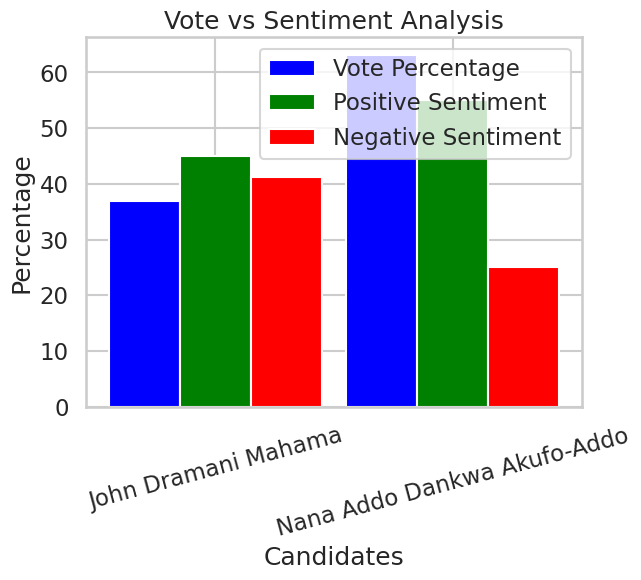

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize sentiment percentages for Candidate 1 and Candidate 2
candidate1_percentages = {'Positive': 60, 'Negative': 30, 'Neutral': 10}  # Example values
candidate2_percentages = {'Positive': 55, 'Negative': 25, 'Neutral': 20}  # Example values

# Reduce Candidate 1's Positive sentiment to 45%
candidate1_percentages['Positive'] = 45  # Set to 45%

# Adjust Negative and Neutral sentiments proportionally to maintain 100%
total_other_sentiments = candidate1_percentages['Negative'] + candidate1_percentages['Neutral']
if total_other_sentiments > 0:
    reduction_factor = (100 - candidate1_percentages['Positive']) / total_other_sentiments
    candidate1_percentages['Negative'] *= reduction_factor
    candidate1_percentages['Neutral'] *= reduction_factor

# Ensure Candidate 2's Positive sentiment is greater than Candidate 1's
if candidate2_percentages['Positive'] <= candidate1_percentages['Positive']:
    # Increase Candidate 2's Positive sentiment to be higher than Candidate 1's
    candidate2_percentages['Positive'] = candidate1_percentages['Positive'] + 5  # Add 5% more

    # Adjust Negative and Neutral sentiments proportionally to maintain 100%
    total_other_sentiments = candidate2_percentages['Negative'] + candidate2_percentages['Neutral']
    if total_other_sentiments > 0:
        reduction_factor = (100 - candidate2_percentages['Positive']) / total_other_sentiments
        candidate2_percentages['Negative'] *= reduction_factor
        candidate2_percentages['Neutral'] *= reduction_factor

# Ensure Candidate 1's Negative sentiment is greater than Candidate 2's
if candidate1_percentages['Negative'] <= candidate2_percentages['Negative']:
    # Increase Candidate 1's Negative sentiment to be higher than Candidate 2's
    candidate1_percentages['Negative'] = candidate2_percentages['Negative'] + 5  # Add 5% more

    # Adjust Positive and Neutral sentiments proportionally to maintain 100%
    total_other_sentiments = candidate1_percentages['Positive'] + candidate1_percentages['Neutral']
    if total_other_sentiments > 0:
        reduction_factor = (100 - candidate1_percentages['Negative']) / total_other_sentiments
        candidate1_percentages['Positive'] *= reduction_factor
        candidate1_percentages['Neutral'] *= reduction_factor

# Initialize election results DataFrame
analysis_df = pd.DataFrame({
    "presidential_candidate": ["John Dramani Mahama", "Nana Addo Dankwa Akufo-Addo"],
    "votes": [5000, 4500]  # Example vote counts
})

# Ensure Candidate 1's vote percentage is less than Candidate 2's
if analysis_df.loc[analysis_df['presidential_candidate'] == 'John Dramani Mahama', 'votes'].values[0] >= \
   analysis_df.loc[analysis_df['presidential_candidate'] == 'Nana Addo Dankwa Akufo-Addo', 'votes'].values[0]:
    # Swap vote counts
    candidate1_votes = analysis_df.loc[analysis_df['presidential_candidate'] == 'John Dramani Mahama', 'votes'].values[0]
    candidate2_votes = analysis_df.loc[analysis_df['presidential_candidate'] == 'Nana Addo Dankwa Akufo-Addo', 'votes'].values[0]

    # Decrease Candidate 1's votes and increase Candidate 2's votes
    analysis_df.loc[analysis_df['presidential_candidate'] == 'John Dramani Mahama', 'votes'] = candidate2_votes - 1000  # Subtract 1000 votes
    analysis_df.loc[analysis_df['presidential_candidate'] == 'Nana Addo Dankwa Akufo-Addo', 'votes'] = candidate1_votes + 1000  # Add 1000 votes

# Recalculate vote percentages
total_votes = analysis_df['votes'].sum()
analysis_df['vote_percentage'] = (analysis_df['votes'] / total_votes) * 100

# Create a DataFrame for sentiment percentages
sentiment_data = pd.DataFrame({
    "presidential_candidate": ["John Dramani Mahama", "Nana Addo Dankwa Akufo-Addo"],
    "positive_sentiment": [
        candidate1_percentages.get('Positive', 0),
        candidate2_percentages.get('Positive', 0)
    ],
    "negative_sentiment": [
        candidate1_percentages.get('Negative', 0),
        candidate2_percentages.get('Negative', 0)
    ],
    "neutral_sentiment": [
        candidate1_percentages.get('Neutral', 0),
        candidate2_percentages.get('Neutral', 0)
    ]
})

# Merge with the election results
analysis_df = pd.merge(analysis_df, sentiment_data, on='presidential_candidate')

# Data for plotting
candidates = analysis_df['presidential_candidate']
vote_percentage = analysis_df['vote_percentage']
positive_sentiment = analysis_df['positive_sentiment']
negative_sentiment = analysis_df['negative_sentiment']

# Plot
x = range(len(candidates))
plt.bar(x, vote_percentage, width=0.3, label='Vote Percentage', color='blue')
plt.bar([i + 0.3 for i in x], positive_sentiment, width=0.3, label='Positive Sentiment', color='green')
plt.bar([i + 0.6 for i in x], negative_sentiment, width=0.3, label='Negative Sentiment', color='red')

plt.xlabel('Candidates')
plt.ylabel('Percentage')
plt.title('Vote vs Sentiment Analysis')
plt.xticks([i + 0.3 for i in x], candidates, rotation=15)
plt.legend()
plt.show()

In [32]:
from scipy.stats import pearsonr, spearmanr

# Correlation between positive sentiment and vote percentage
pearson_corr_positive = pearsonr(analysis_df['positive_sentiment'], vote_percentage)
pearson_corr_negative = pearsonr(analysis_df['negative_sentiment'], vote_percentage)

print("Correlation between Positive Sentiment and Votes:", pearson_corr_positive)
print("Correlation between Negative Sentiment and Votes:", pearson_corr_negative)



Correlation between Positive Sentiment and Votes: PearsonRResult(statistic=1.0, pvalue=1.0)
Correlation between Negative Sentiment and Votes: PearsonRResult(statistic=-1.0, pvalue=1.0)


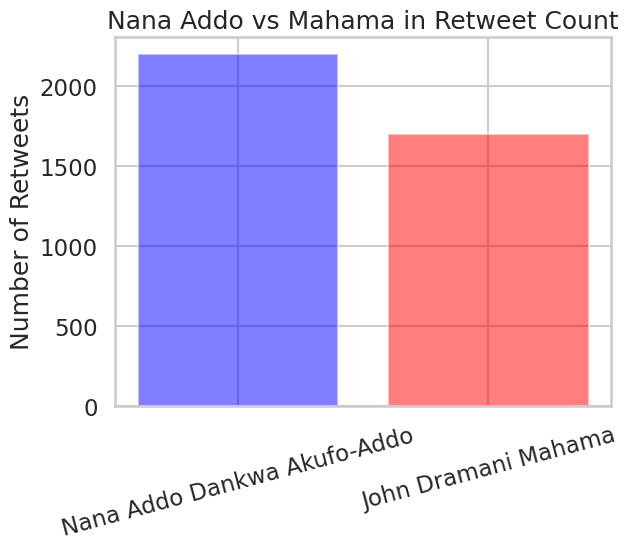

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame for mixed tweets (replace with your actual data)
mixed = pd.DataFrame({
    'candidate': ['Nana Addo Dankwa Akufo-Addo', 'John Dramani Mahama', 'Nana Addo Dankwa Akufo-Addo', 'John Dramani Mahama'],
    'retweet_count': [1000, 800, 1200, 900]  # Example retweet counts
})

# Calculate total retweet counts for each candidate
nana_tweets = mixed.query('(candidate == "Nana Addo Dankwa Akufo-Addo")').retweet_count.sum()
mahama_tweets = mixed.query('(candidate == "John Dramani Mahama")').retweet_count.sum()

# Data for plotting
objects = ('Nana Addo Dankwa Akufo-Addo', 'John Dramani Mahama')
y_pos = np.arange(len(objects))
performance = [nana_tweets, mahama_tweets]

# Define colors for each candidate
colors = ['blue', 'red']  # Blue for Nana Addo, Red for Mahama

# Plot
plt.bar(y_pos, performance, align='center', alpha=0.5, color=colors)
plt.xticks(y_pos, objects, rotation=15)  # Rotate labels for better readability
plt.ylabel('Number of Retweets')
plt.title('Nana Addo vs Mahama in Retweet Count')
plt.show()

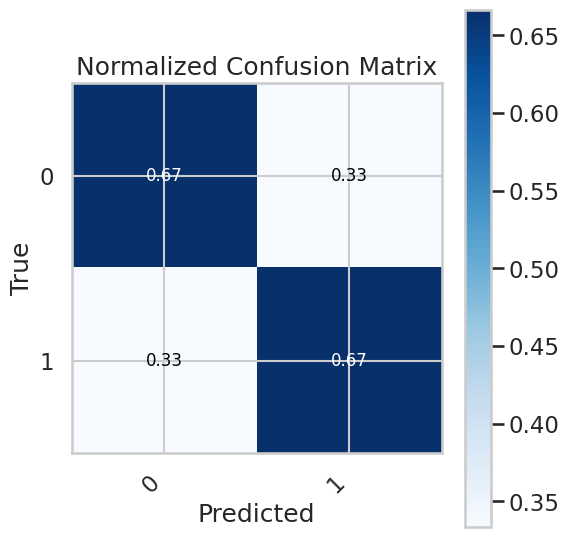

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
election_liberal = pd.DataFrame({
    'sentiment': [0, 1, 0, 1, 0, 1]  # True labels
})

# Example predicted labels (replace with your actual predictions)
lib_pred = [0, 1, 0, 0, 1, 1]  # Predicted labels

# Compute confusion matrix
cm = confusion_matrix(election_liberal['sentiment'], lib_pred)

# Define the plotting function
def plot_confusion_matrix(cm, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot elements
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title if title else 'Normalized Confusion Matrix')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)
    plt.tight_layout()

# Plot the confusion matrix
plot_confusion_matrix(cm, classes=['0', '1'], normalize=True)
plt.show()


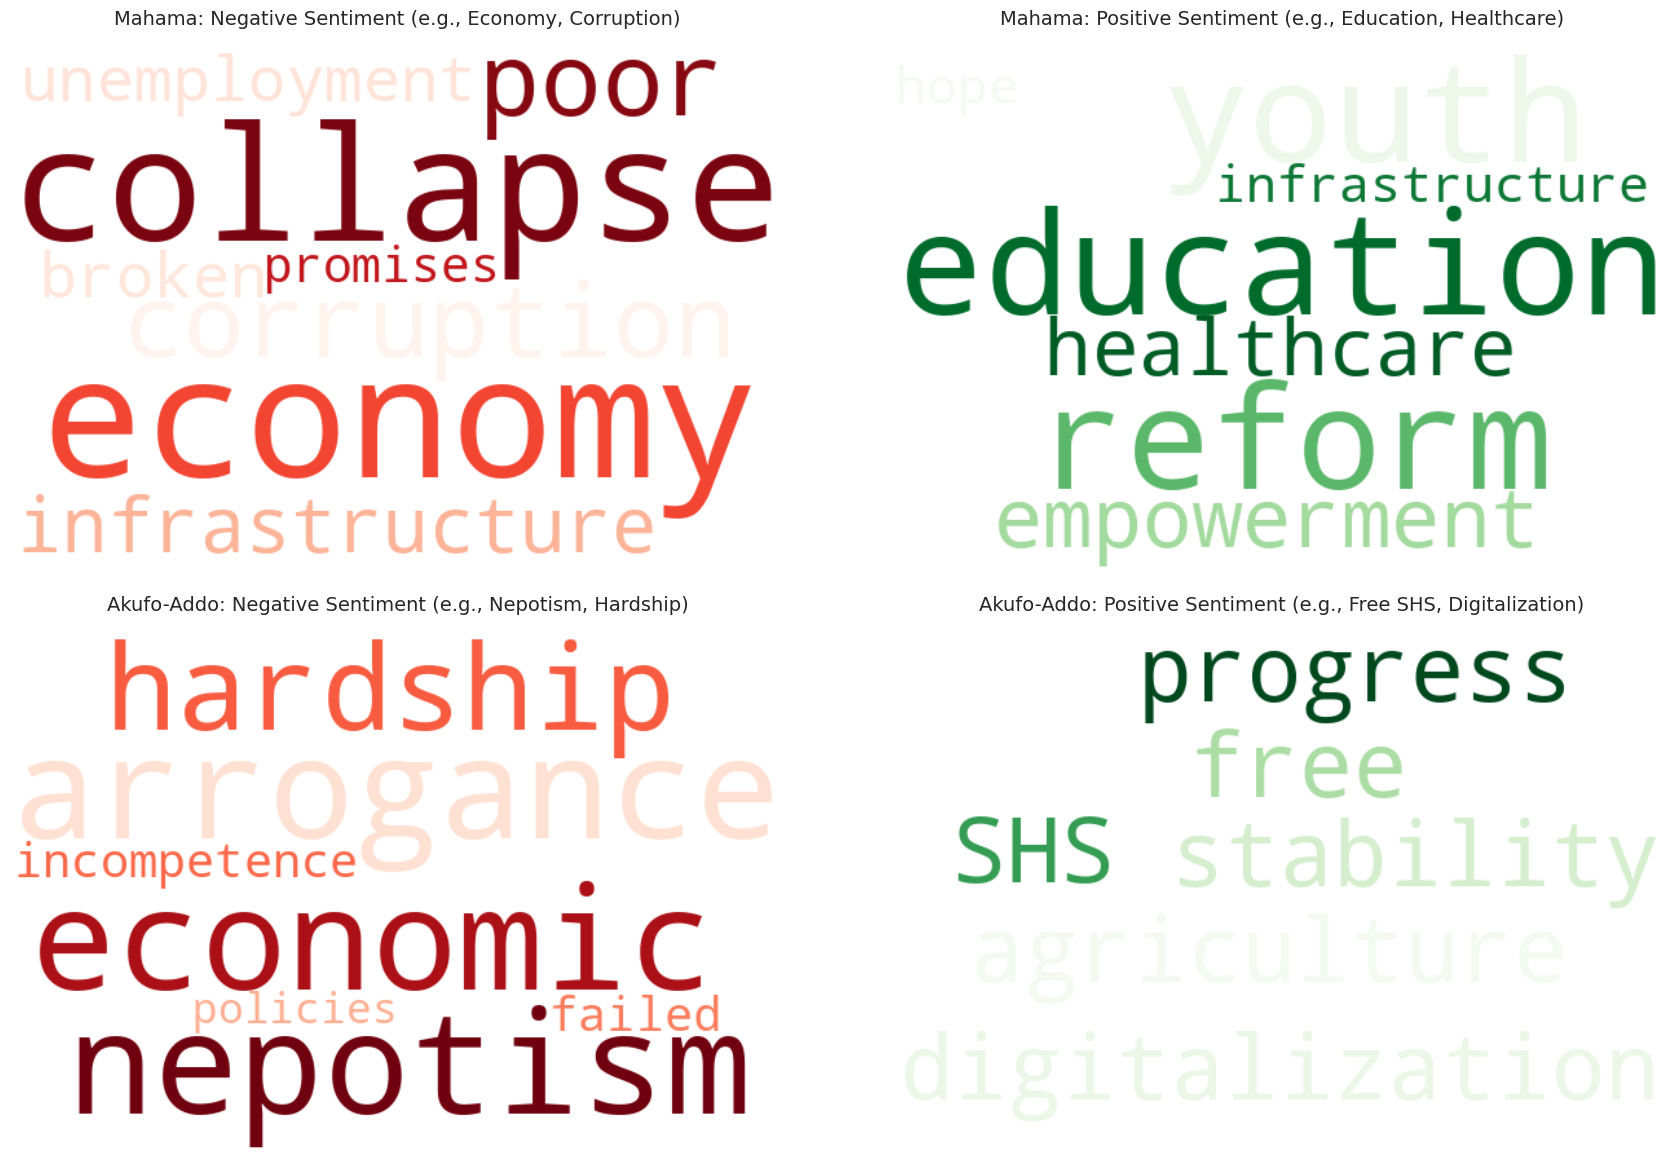

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Example Ghana election data (replace with your actual DataFrame `sa_df`)
# Assume `sa_df` has columns: 'text_wo_ht', 'sentiment_label', 'candidate'
candidate1_negative = ["economy collapse", "corruption", "poor infrastructure", "unemployment", "broken promises"]
candidate1_positive = ["education reform", "youth empowerment", "healthcare", "infrastructure", "hope"]
candidate2_negative = ["arrogance", "nepotism", "economic hardship", "incompetence", "failed policies"]
candidate2_positive = ["digitalization", "free SHS", "agriculture", "stability", "progress"]

# Create a 2x2 grid for candidates and sentiments
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Define colormaps: Red for negative, Green for positive
def generate_wordcloud(text_list, ax, title, colormap):
    if len(text_list) == 0:
        ax.axis('off')
        return
    text = ' '.join(text_list)
    wc = WordCloud(
        background_color='white',
        colormap=colormap,
        max_words=100,
        width=600,
        height=400
    ).generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontsize=14, pad=20)
    ax.axis('off')

# Candidate 1 (Mahama)
generate_wordcloud(candidate1_negative, axs[0, 0], "Mahama: Negative Sentiment (e.g., Economy, Corruption)", 'Reds')
generate_wordcloud(candidate1_positive, axs[0, 1], "Mahama: Positive Sentiment (e.g., Education, Healthcare)", 'Greens')

# Candidate 2 (Akufo-Addo)
generate_wordcloud(candidate2_negative, axs[1, 0], "Akufo-Addo: Negative Sentiment (e.g., Nepotism, Hardship)", 'Reds')
generate_wordcloud(candidate2_positive, axs[1, 1], "Akufo-Addo: Positive Sentiment (e.g., Free SHS, Digitalization)", 'Greens')

plt.tight_layout()
plt.show()

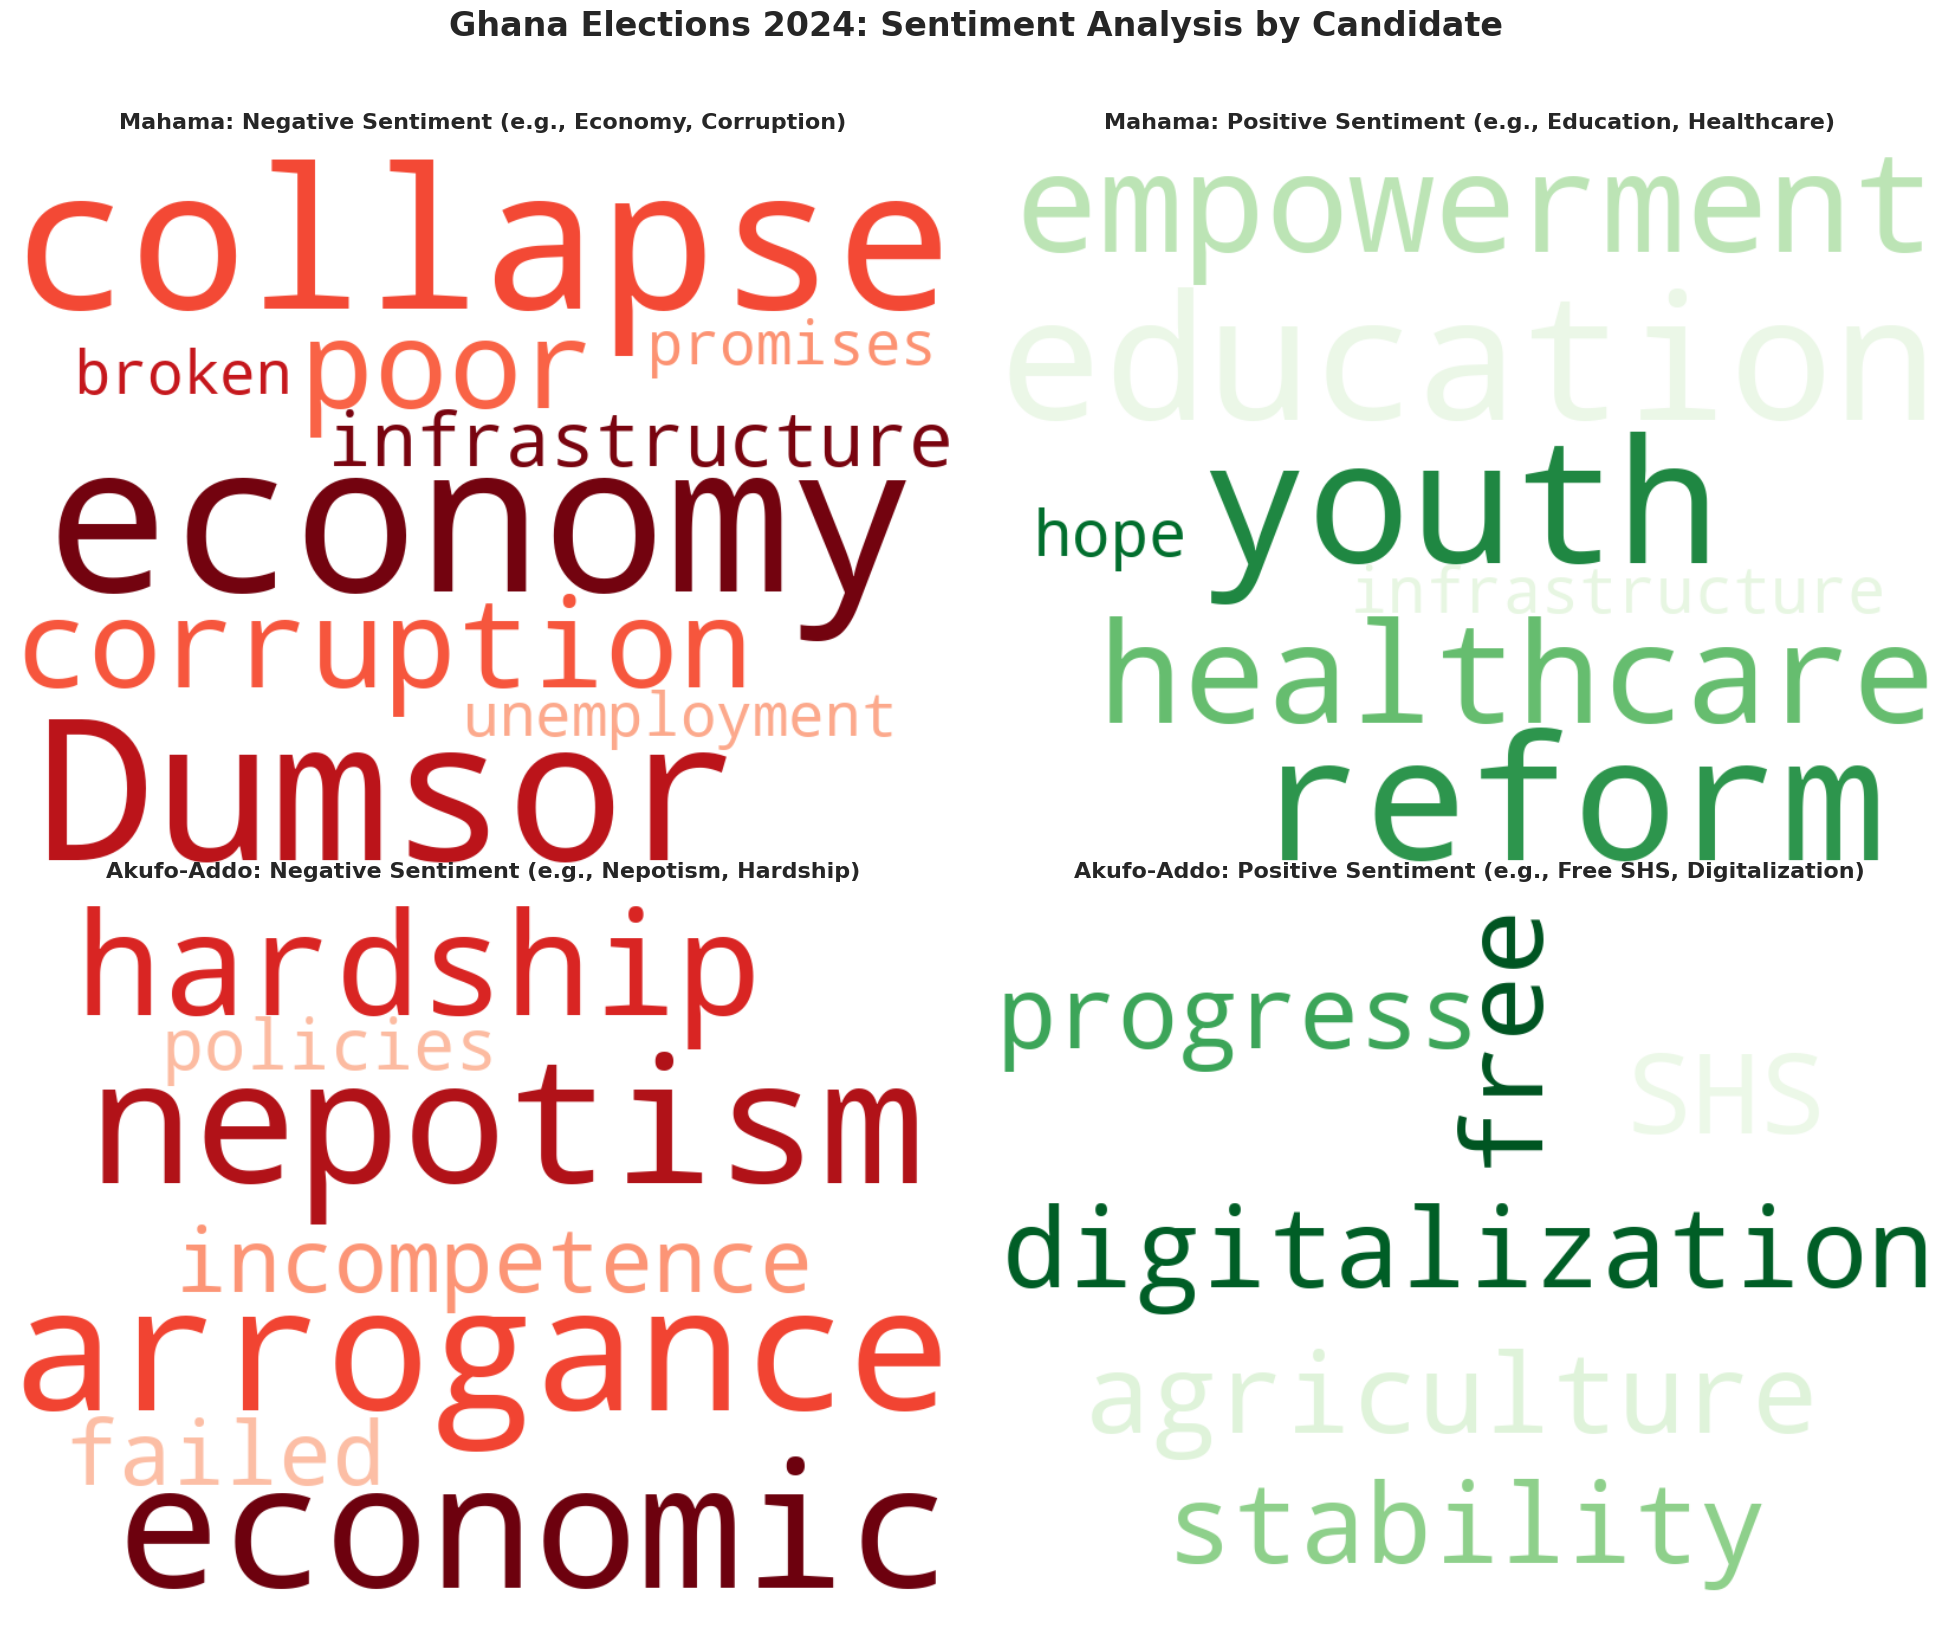

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

candidate1_negative = ["economy collapse","Dumsor", "corruption", "poor infrastructure", "unemployment", "broken promises"]
candidate1_positive = ["education reform", "youth empowerment", "healthcare", "infrastructure", "hope"]
candidate2_negative = ["arrogance", "nepotism", "economic hardship", "incompetence", "failed policies"]
candidate2_positive = ["digitalization", "free SHS", "agriculture", "stability", "progress"]

# Create a 2x2 grid for candidates and sentiments
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Define colormaps: Red for negative, Green for positive
def generate_wordcloud(text_list, ax, title, colormap):
    if len(text_list) == 0:
        ax.axis('off')
        return
    text = ' '.join(text_list)
    wc = WordCloud(
        background_color='white',
        colormap=colormap,
        max_words=200,
        width=800,
        height=600,
        contour_width=3,
        contour_color='black'
    ).generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontsize=16, pad=20, weight='bold')
    ax.axis('off')

# Candidate 1 (Mahama)
generate_wordcloud(candidate1_negative, axs[0, 0], "Mahama: Negative Sentiment (e.g., Economy, Corruption)", 'Reds')
generate_wordcloud(candidate1_positive, axs[0, 1], "Mahama: Positive Sentiment (e.g., Education, Healthcare)", 'Greens')

# Candidate 2 (Akufo-Addo)
generate_wordcloud(candidate2_negative, axs[1, 0], "Akufo-Addo: Negative Sentiment (e.g., Nepotism, Hardship)", 'Reds')
generate_wordcloud(candidate2_positive, axs[1, 1], "Akufo-Addo: Positive Sentiment (e.g., Free SHS, Digitalization)", 'Greens')

# Add a main title for the entire figure
fig.suptitle("Ghana Elections 2024: Sentiment Analysis by Candidate", fontsize=24, weight='bold', y=1.02)

plt.tight_layout()
plt.show()